In [ ]:
# Imports
import io
import os
import time
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_recall_fscore_support
)

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

from google.colab import files

warnings.filterwarnings("ignore") # Suppressing warnings
sns.set(style="whitegrid")
RANDOM_STATE = 42

In [ ]:
# LOADING THE DATASET

print("Upload the 10 NRC emotion files")
uploaded = files.upload()

# Lexicon emotion categories
emotions = [
    'anger', 'anticipation', 'disgust', 'fear', 'joy',
    'negative', 'positive', 'sadness', 'surprise', 'trust'
]

dfs = []

# extracts words with label = 1 for each emotion
for filename in uploaded:
    for emotion in emotions:
        if emotion in filename.lower():
            lines = io.BytesIO(uploaded[filename]).read().decode("utf-8").splitlines()
            words = [l.split('\t')[0].lower().strip() for l in lines if l.endswith('\t1')]
            dfs.append(pd.DataFrame({"word": words, "emotion": emotion}))
            print(f"Loaded {emotion}: {len(words)} words")
            break

# Combines all emotion files into a single dataframe
df = pd.concat(dfs, ignore_index=True).drop_duplicates()
print("\nTotal (word, emotion) pairs:", len(df))

Upload the 10 NRC emotion files


Saving anger-NRC-Emotion-Lexicon.txt to anger-NRC-Emotion-Lexicon (2).txt
Saving anticipation-NRC-Emotion-Lexicon.txt to anticipation-NRC-Emotion-Lexicon (2).txt
Saving disgust-NRC-Emotion-Lexicon.txt to disgust-NRC-Emotion-Lexicon (2).txt
Saving fear-NRC-Emotion-Lexicon.txt to fear-NRC-Emotion-Lexicon (2).txt
Saving joy-NRC-Emotion-Lexicon.txt to joy-NRC-Emotion-Lexicon (2).txt
Saving negative-NRC-Emotion-Lexicon.txt to negative-NRC-Emotion-Lexicon (2).txt
Saving positive-NRC-Emotion-Lexicon.txt to positive-NRC-Emotion-Lexicon (2).txt
Saving sadness-NRC-Emotion-Lexicon.txt to sadness-NRC-Emotion-Lexicon (2).txt
Saving surprise-NRC-Emotion-Lexicon.txt to surprise-NRC-Emotion-Lexicon (2).txt
Saving trust-NRC-Emotion-Lexicon.txt to trust-NRC-Emotion-Lexicon (2).txt
Loaded anger: 1245 words
Loaded anticipation: 837 words
Loaded disgust: 1056 words
Loaded fear: 1474 words
Loaded joy: 687 words
Loaded negative: 3316 words
Loaded positive: 2308 words
Loaded sadness: 1187 words
Loaded surpris

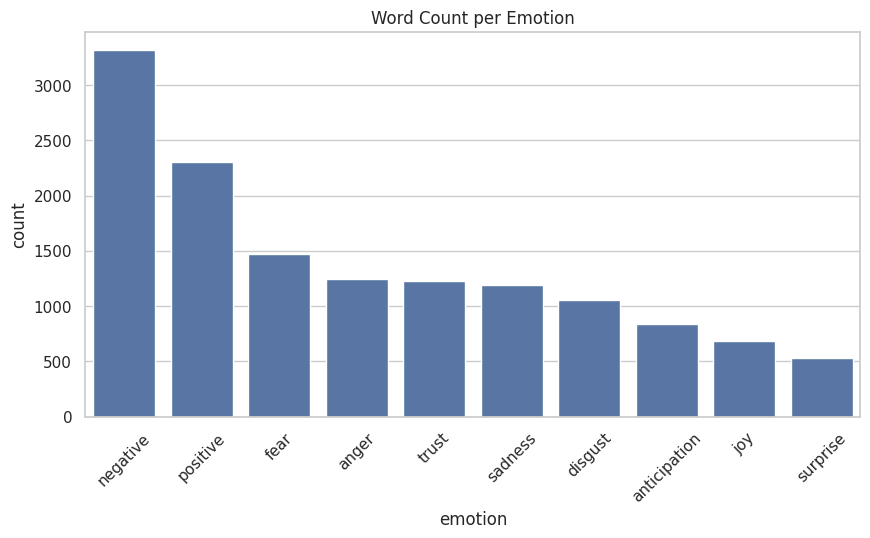

In [ ]:
# EXPLORATORY DATA ANALYSIS (EDA)

# Distribution of words per emotion
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="emotion", order=df["emotion"].value_counts().index)
plt.title("Word Count per Emotion")
plt.xticks(rotation=45)
plt.show()

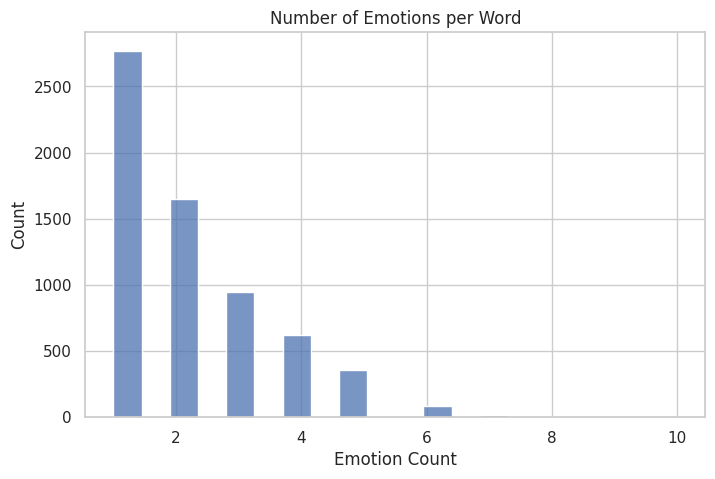

Average emotions per word: 2.1496978149697816


In [ ]:
# Number of emotions assigned to each word
word_emotion_counts = df.groupby("word")["emotion"].nunique()

plt.figure(figsize=(8,5))
sns.histplot(word_emotion_counts, bins=20)
plt.title("Number of Emotions per Word")
plt.xlabel("Emotion Count")
plt.show()

print("Average emotions per word:", word_emotion_counts.mean())

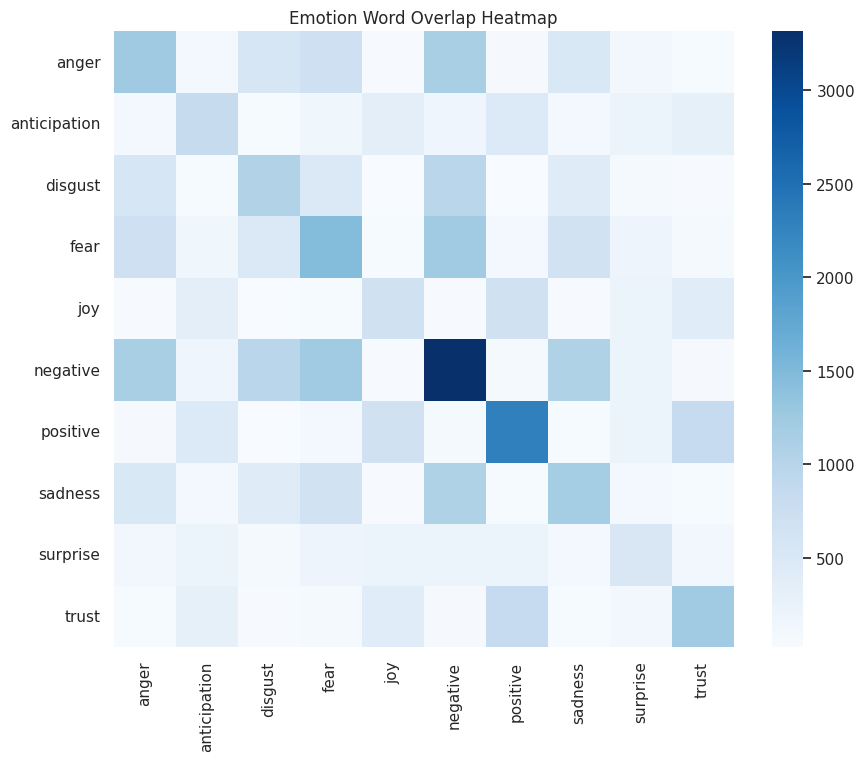

In [ ]:
# Compute overlap between emotion vocabularies
emotion_sets = {
    e: set(df[df.emotion == e].word) for e in emotions
}

overlap_matrix = pd.DataFrame(index=emotions, columns=emotions)

for e1 in emotions:
    for e2 in emotions:
        overlap_matrix.loc[e1, e2] = len(emotion_sets[e1] & emotion_sets[e2])

plt.figure(figsize=(10,8))
sns.heatmap(overlap_matrix.astype(int), cmap="Blues", annot=False)
plt.title("Emotion Word Overlap Heatmap")
plt.show()

,Emotion Pair,Shared Words
25,fear & negative,1230
4,anger & negative,1145
36,negative & sadness,1066
19,disgust & negative,969
41,positive & trust,852
2,anger & fear,703
31,joy & positive,676
27,fear & sadness,657
1,anger & disgust,549
6,anger & sadness,519


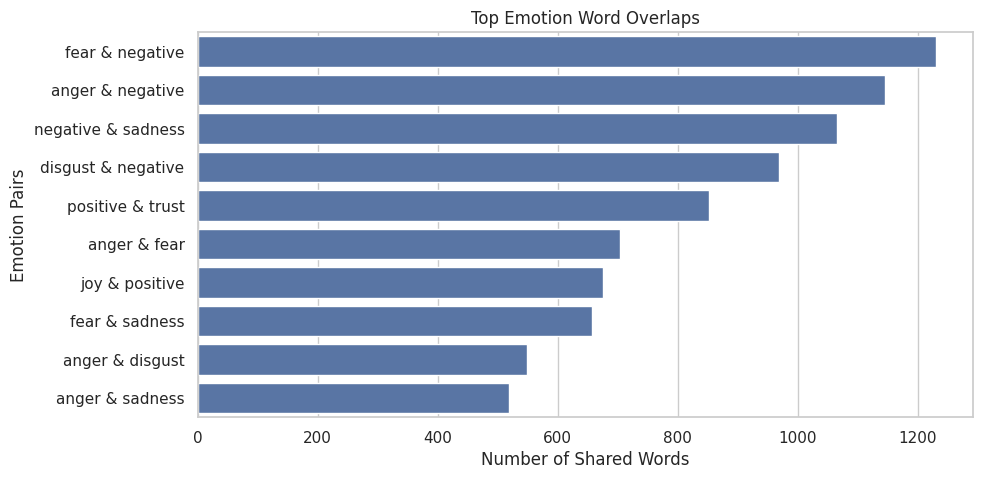

In [ ]:
# Emotion Pairwise Overlap Analysis

from itertools import combinations

# Build sets of words per emotion
emotion_sets = {
    emotion: set(df[df["emotion"] == emotion]["word"])
    for emotion in df["emotion"].unique()
}

# Compute pairwise overlaps
overlap_records = []

for e1, e2 in combinations(emotion_sets.keys(), 2):
    shared_words = emotion_sets[e1] & emotion_sets[e2]
    overlap_records.append({
        "Emotion Pair": f"{e1} & {e2}",
        "Shared Words": len(shared_words)
    })

overlap_df = (
    pd.DataFrame(overlap_records)
    .sort_values("Shared Words", ascending=False)
)

# Display top overlaps
display(overlap_df.head(10))

# Plot top N emotion overlaps
TOP_N = 10

plt.figure(figsize=(10, 5))
sns.barplot(
    data=overlap_df.head(TOP_N),
    x="Shared Words",
    y="Emotion Pair",
    orient="h"
)
plt.title("Top Emotion Word Overlaps")
plt.xlabel("Number of Shared Words")
plt.ylabel("Emotion Pairs")
plt.show()


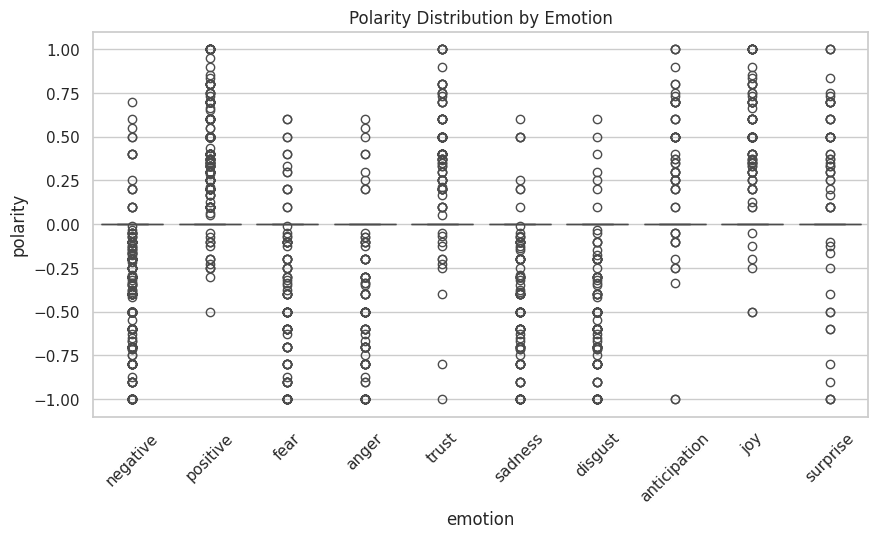

In [ ]:
# Polarity Analysis
# Attach polarity to word-emotion pairs
df_pol = df.merge(
    lex_df[["word", "polarity", "subjectivity"]],
    on="word",
    how="left"
)
# Polarity distribution per emotion
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_pol,
    x="emotion",
    y="polarity",
    order=df_pol["emotion"].value_counts().index
)
plt.xticks(rotation=45)
plt.title("Polarity Distribution by Emotion")
plt.show()


In [ ]:
# DATA PREPARATION

X = lex_df["word"]

# Multi-label targets are emotion sets per word
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(lex_df["emotion"])

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Classes:", mlb.classes_)

Classes: ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'negative' 'positive'
 'sadness' 'surprise' 'trust']


In [ ]:
def deep_model_analysis(
    model_name,
    y_true,
    y_pred,
    classes,
    X_test=None,
    top_k_errors=10
):
    """
    Performs error analysis for a multi-label classifier
    """
    print(f"\n{model_name}")

    # Overall Metrics
    print("\nOverall Performance:")
    print("F1 Micro:", f1_score(y_true, y_pred, average="micro"))
    print("F1 Macro:", f1_score(y_true, y_pred, average="macro"))
    print("Subset Accuracy:", accuracy_score(y_true, y_pred))

    #  Per-Label Classification Report
    print("\nClassification Report (Per Emotion):")
    print(classification_report(
        y_true,
        y_pred,
        target_names=classes,
        zero_division=0
    ))

    # Prediction Bias Analysis
    label_support = y_true.sum(axis=0)
    label_predictions = y_pred.sum(axis=0)

    bias_df = pd.DataFrame({
        "Emotion": classes,
        "True Support": label_support,
        "Predicted Count": label_predictions,
        "Prediction / True Ratio": np.round(
            label_predictions / np.maximum(label_support, 1), 2
        )
    }).sort_values("Prediction / True Ratio", ascending=False)

    print("\nPrediction Bias (Over/Under Prediction):")
    display(bias_df)

    # Error Density
    errors_per_sample = np.sum(y_true != y_pred, axis=1)
    print("\nError Density:")
    print(pd.Series(errors_per_sample).value_counts().sort_index())

In [ ]:
# BASELINE MODELS

# Baseline 1: Majority Label Baseline
# Predicts the most frequent emotions for every instance
label_freq = y_train.mean(axis=0)
majority_threshold = 0.5 * label_freq.max()

majority_pred = (np.tile(label_freq, (len(y_test), 1)) >= majority_threshold).astype(int)

deep_model_analysis(
    model_name="Majority Baseline",
    y_true=y_test,
    y_pred=majority_pred,
    classes=mlb.classes_,
    X_test=X_test
)

# Baseline 2: CountVectorizer + Logistic Regression
# Tests if TF-IDF actually helps more than raw counts
from sklearn.feature_extraction.text import CountVectorizer

count_baseline = Pipeline([
    ("vec", CountVectorizer(analyzer="char_wb", ngram_range=(2,5))),
    ("clf", OneVsRestClassifier(LogisticRegression(max_iter=2000)))
])

count_baseline.fit(X_train, y_train)
count_preds = count_baseline.predict(X_test)

deep_model_analysis(
    model_name="CountVectorizer + Logistic Regression",
    y_true=y_test,
    y_pred=count_preds,
    classes=mlb.classes_,
    X_test=X_test
)



Majority Baseline

Overall Performance:
F1 Micro: 0.4162323157110946
F1 Macro: 0.11968545523898948
Subset Accuracy: 0.0023237800154918666

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       281
anticipation       0.00      0.00      0.00       155
     disgust       0.00      0.00      0.00       225
        fear       0.00      0.00      0.00       314
         joy       0.00      0.00      0.00       132
    negative       0.53      1.00      0.69       679
    positive       0.34      1.00      0.51       439
     sadness       0.00      0.00      0.00       238
    surprise       0.00      0.00      0.00       100
       trust       0.00      0.00      0.00       227

   micro avg       0.43      0.40      0.42      2790
   macro avg       0.09      0.20      0.12      2790
weighted avg       0.18      0.40      0.25      2790
 samples avg       0.43      0.50      0.43      2790


Predictio

,Emotion,True Support,Predicted Count,Prediction / True Ratio
6,positive,439,1291,2.94
5,negative,679,1291,1.90
1,anticipation,155,0,0.00
0,anger,281,0,0.00
3,fear,314,0,0.00
2,disgust,225,0,0.00
4,joy,132,0,0.00
7,sadness,238,0,0.00
8,surprise,100,0,0.00
9,trust,227,0,0.00



Error Density:
0      3
1    373
2    326
3    355
4    145
5     72
6     13
7      4
Name: count, dtype: int64

CountVectorizer + Logistic Regression

Overall Performance:
F1 Micro: 0.45012219506776274
F1 Macro: 0.305879356632021
Subset Accuracy: 0.14717273431448488

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       0.57      0.22      0.31       281
anticipation       0.24      0.08      0.12       155
     disgust       0.45      0.16      0.24       225
        fear       0.53      0.27      0.35       314
         joy       0.44      0.13      0.20       132
    negative       0.72      0.73      0.73       679
    positive       0.59      0.49      0.54       439
     sadness       0.44      0.17      0.24       238
    surprise       0.20      0.03      0.05       100
       trust       0.42      0.20      0.27       227

   micro avg       0.59      0.36      0.45      2790
   macro avg       0.46      0.25      0.3

,Emotion,True Support,Predicted Count,Prediction / True Ratio
5,negative,679,696,1.03
6,positive,439,360,0.82
3,fear,314,160,0.51
9,trust,227,109,0.48
7,sadness,238,91,0.38
0,anger,281,107,0.38
2,disgust,225,80,0.36
1,anticipation,155,54,0.35
4,joy,132,39,0.30
8,surprise,100,15,0.15



Error Density:
0    190
1    343
2    388
3    210
4    101
5     42
6     10
7      4
8      3
Name: count, dtype: int64


In [ ]:
# CLASSIFIER COMPARISON

# Shared TF-IDF configuration
tfidf = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(2,5),
    min_df=2
)
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Linear SVM": LinearSVC(class_weight="balanced"),
    "Multinomial NB": MultinomialNB()
}
results = []

# Train and evaluate for each classifier
for name, clf in models.items():
    pipe = Pipeline([
        ("tfidf", tfidf),
        ("clf", OneVsRestClassifier(clf))
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    # Store summary metrics
    f1_micro = f1_score(y_test, preds, average="micro")
    f1_macro = f1_score(y_test, preds, average="macro")
    results.append([name, f1_micro, f1_macro])

    # error analysis
    deep_model_analysis(
        model_name=name,
        y_true=y_test,
        y_pred=preds,
        classes=mlb.classes_,
        X_test=X_test
    )


results_df = pd.DataFrame(
    results, columns=["Model", "F1-Micro", "F1-Macro"]
).sort_values("F1-Micro", ascending=False)

results_df



Logistic Regression

Overall Performance:
F1 Micro: 0.4473520249221184
F1 Macro: 0.38176313566996106
Subset Accuracy: 0.06816421378776143

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       0.35      0.47      0.40       281
anticipation       0.18      0.30      0.22       155
     disgust       0.31      0.44      0.36       225
        fear       0.34      0.44      0.38       314
         joy       0.22      0.36      0.27       132
    negative       0.70      0.70      0.70       679
    positive       0.51      0.58      0.54       439
     sadness       0.30      0.42      0.35       238
    surprise       0.15      0.26      0.19       100
       trust       0.31      0.52      0.39       227

   micro avg       0.40      0.51      0.45      2790
   macro avg       0.34      0.45      0.38      2790
weighted avg       0.43      0.51      0.46      2790
 samples avg       0.41      0.54      0.42      2790


Predictio

,Emotion,True Support,Predicted Count,Prediction / True Ratio
8,surprise,100,169,1.69
1,anticipation,155,255,1.65
9,trust,227,372,1.64
4,joy,132,214,1.62
7,sadness,238,342,1.44
2,disgust,225,317,1.41
0,anger,281,376,1.34
3,fear,314,405,1.29
6,positive,439,501,1.14
5,negative,679,679,1.00



Error Density:
0     88
1    236
2    318
3    261
4    174
5    125
6     60
7     20
8      9
Name: count, dtype: int64

Linear SVM

Overall Performance:
F1 Micro: 0.45807427323138966
F1 Macro: 0.37956243435441966
Subset Accuracy: 0.09604957397366383

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       0.39      0.43      0.41       281
anticipation       0.19      0.25      0.22       155
     disgust       0.37      0.41      0.39       225
        fear       0.36      0.41      0.39       314
         joy       0.24      0.30      0.27       132
    negative       0.71      0.70      0.70       679
    positive       0.55      0.61      0.58       439
     sadness       0.32      0.38      0.35       238
    surprise       0.13      0.17      0.15       100
       trust       0.31      0.42      0.35       227

   micro avg       0.43      0.49      0.46      2790
   macro avg       0.36      0.41      0.38      2790
weig

,Emotion,True Support,Predicted Count,Prediction / True Ratio
9,trust,227,309,1.36
8,surprise,100,134,1.34
1,anticipation,155,204,1.32
4,joy,132,164,1.24
7,sadness,238,288,1.21
3,fear,314,354,1.13
2,disgust,225,251,1.12
0,anger,281,308,1.10
6,positive,439,481,1.10
5,negative,679,668,0.98



Error Density:
0    124
1    251
2    334
3    274
4    162
5     75
6     47
7     13
8     11
Name: count, dtype: int64

Multinomial NB

Overall Performance:
F1 Micro: 0.3238199780461032
F1 Macro: 0.10998182841020954
Subset Accuracy: 0.13013168086754454

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       1.00      0.00      0.01       281
anticipation       0.00      0.00      0.00       155
     disgust       0.00      0.00      0.00       225
        fear       1.00      0.00      0.01       314
         joy       0.00      0.00      0.00       132
    negative       0.68      0.71      0.69       679
    positive       0.73      0.24      0.36       439
     sadness       1.00      0.00      0.01       238
    surprise       0.00      0.00      0.00       100
       trust       0.60      0.01      0.03       227

   micro avg       0.69      0.21      0.32      2790
   macro avg       0.50      0.10      0.11      2790
w

,Emotion,True Support,Predicted Count,Prediction / True Ratio
5,negative,679,704,1.04
6,positive,439,142,0.32
9,trust,227,5,0.02
0,anger,281,1,0.00
1,anticipation,155,0,0.00
2,disgust,225,0,0.00
4,joy,132,0,0.00
3,fear,314,1,0.00
7,sadness,238,1,0.00
8,surprise,100,0,0.00



Error Density:
0    168
1    383
2    385
3    183
4    111
5     53
6      4
7      3
8      1
Name: count, dtype: int64


,Model,F1-Micro,F1-Macro
1,Linear SVM,0.458074,0.379562
0,Logistic Regression,0.447352,0.381763
2,Multinomial NB,0.323820,0.109982


In [ ]:
# HYPERPARAMETER OPTIMIZATION (HPO)

# Logistic Regression HPO
logreg_hpo = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", OneVsRestClassifier(
        LogisticRegression(max_iter=2000, class_weight="balanced")
    ))
])

logreg_param_dist = {
    "tfidf__analyzer": ["char", "char_wb"],
    "tfidf__ngram_range": [(2,4), (2,5), (3,6)],
    "tfidf__max_features": [5000, 10000, 20000],
    "clf__estimator__C": loguniform(1e-3, 10)
}

logreg_search = RandomizedSearchCV(
    logreg_hpo,
    logreg_param_dist,
    n_iter=15,
    scoring="f1_micro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

logreg_search.fit(X_train, y_train)
best_logreg = logreg_search.best_estimator_


Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
# Linear SVM HPO
svm_hpo = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", OneVsRestClassifier(
        LinearSVC(class_weight="balanced")
    ))
])

svm_param_dist = {
    "tfidf__analyzer": ["char", "char_wb"],
    "tfidf__ngram_range": [(2,4), (2,5)],
    "tfidf__max_features": [5000, 15000],
    "clf__estimator__C": loguniform(1e-3, 10)
}

svm_search = RandomizedSearchCV(
    svm_hpo,
    svm_param_dist,
    n_iter=10,
    scoring="f1_micro",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
deep_model_analysis(
    "HPO Logistic Regression",
    y_test,
    best_logreg.predict(X_test),
    mlb.classes_,
    X_test
)

deep_model_analysis(
    "HPO Linear SVM",
    y_test,
    best_svm.predict(X_test),
    mlb.classes_,
    X_test
)


HPO Logistic Regression

Overall Performance:
F1 Micro: 0.44562243502051985
F1 Macro: 0.36935504083342957
Subset Accuracy: 0.09604957397366383

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       0.38      0.37      0.37       281
anticipation       0.16      0.20      0.18       155
     disgust       0.35      0.40      0.37       225
        fear       0.39      0.41      0.40       314
         joy       0.27      0.34      0.30       132
    negative       0.69      0.68      0.69       679
    positive       0.53      0.57      0.55       439
     sadness       0.32      0.37      0.34       238
    surprise       0.15      0.18      0.16       100
       trust       0.29      0.39      0.33       227

   micro avg       0.43      0.47      0.45      2790
   macro avg       0.35      0.39      0.37      2790
weighted avg       0.44      0.47      0.45      2790
 samples avg       0.42      0.50      0.41      2790


Pred

,Emotion,True Support,Predicted Count,Prediction / True Ratio
9,trust,227,303,1.33
4,joy,132,167,1.27
1,anticipation,155,195,1.26
8,surprise,100,121,1.21
7,sadness,238,272,1.14
2,disgust,225,252,1.12
6,positive,439,471,1.07
3,fear,314,332,1.06
5,negative,679,672,0.99
0,anger,281,273,0.97



Error Density:
0    124
1    251
2    325
3    276
4    153
5     96
6     47
7     13
8      6
Name: count, dtype: int64

HPO Linear SVM

Overall Performance:
F1 Micro: 0.455749354005168
F1 Macro: 0.38161711410234667
Subset Accuracy: 0.07823392718822618

Classification Report (Per Emotion):
              precision    recall  f1-score   support

       anger       0.39      0.46      0.42       281
anticipation       0.18      0.27      0.22       155
     disgust       0.33      0.43      0.37       225
        fear       0.36      0.43      0.39       314
         joy       0.22      0.31      0.26       132
    negative       0.71      0.71      0.71       679
    positive       0.54      0.60      0.57       439
     sadness       0.30      0.42      0.35       238
    surprise       0.14      0.21      0.17       100
       trust       0.30      0.45      0.36       227

   micro avg       0.41      0.51      0.46      2790
   macro avg       0.35      0.43      0.38      2790
we

,Emotion,True Support,Predicted Count,Prediction / True Ratio
8,surprise,100,154,1.54
9,trust,227,344,1.52
1,anticipation,155,231,1.49
4,joy,132,186,1.41
7,sadness,238,327,1.37
2,disgust,225,289,1.28
0,anger,281,334,1.19
3,fear,314,374,1.19
6,positive,439,489,1.11
5,negative,679,674,0.99



Error Density:
0    101
1    246
2    320
3    286
4    167
5     98
6     50
7     16
8      7
Name: count, dtype: int64


In [ ]:
# ERROR ANALYSIS

all_models = { # Collecting predictions for every model
    "Majority Baseline": majority_pred,
    "CountVectorizer Baseline": count_preds,
}

# Default models
for name, clf in models.items():
    pipe = Pipeline([
        ("tfidf", tfidf),
        ("clf", OneVsRestClassifier(clf))
    ])
    pipe.fit(X_train, y_train)
    all_models[name] = pipe.predict(X_test)

# HPO models
all_models["HPO Logistic Regression"] = best_logreg.predict(X_test)
all_models["HPO Linear SVM"] = best_svm.predict(X_test)


In [ ]:
# Per-emotion metrics
def per_emotion_metrics(y_true, y_pred, classes):
    """Compute precision, recall, and F1 for each emotion."""
    pr, rc, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    return pd.DataFrame({
        "Emotion": classes,
        "Precision": pr,
        "Recall": rc,
        "F1": f1,
        "Support": sup
    }).sort_values("F1")
per_emotion_reports = {}

for name, preds in all_models.items():
    report = per_emotion_metrics(y_test, preds, mlb.classes_)
    per_emotion_reports[name] = report

    print(f"\n Worst emotions — {name}")
    display(report.head(5))



 Worst emotions — Majority Baseline


,Emotion,Precision,Recall,F1,Support
0,anger,0.0,0.0,0.0,281
1,anticipation,0.0,0.0,0.0,155
2,disgust,0.0,0.0,0.0,225
3,fear,0.0,0.0,0.0,314
4,joy,0.0,0.0,0.0,132



 Worst emotions — CountVectorizer Baseline


,Emotion,Precision,Recall,F1,Support
8,surprise,0.200000,0.030000,0.052174,100
1,anticipation,0.240741,0.083871,0.124402,155
4,joy,0.435897,0.128788,0.198830,132
2,disgust,0.450000,0.160000,0.236066,225
7,sadness,0.439560,0.168067,0.243161,238



 Worst emotions — Logistic Regression


,Emotion,Precision,Recall,F1,Support
8,surprise,0.153846,0.260000,0.193309,100
1,anticipation,0.180392,0.296774,0.224390,155
4,joy,0.219626,0.356061,0.271676,132
7,sadness,0.295322,0.424370,0.348276,238
2,disgust,0.309148,0.435556,0.361624,225



 Worst emotions — Linear SVM


,Emotion,Precision,Recall,F1,Support
8,surprise,0.126866,0.170000,0.145299,100
1,anticipation,0.191176,0.251613,0.217270,155
4,joy,0.243902,0.303030,0.270270,132
7,sadness,0.315972,0.382353,0.346008,238
9,trust,0.307443,0.418502,0.354478,227



 Worst emotions — Multinomial NB


,Emotion,Precision,Recall,F1,Support
1,anticipation,0.0,0.000000,0.000000,155
2,disgust,0.0,0.000000,0.000000,225
4,joy,0.0,0.000000,0.000000,132
8,surprise,0.0,0.000000,0.000000,100
3,fear,1.0,0.003185,0.006349,314



 Worst emotions — HPO Logistic Regression


,Emotion,Precision,Recall,F1,Support
8,surprise,0.148760,0.180000,0.162896,100
1,anticipation,0.158974,0.200000,0.177143,155
4,joy,0.269461,0.340909,0.301003,132
9,trust,0.290429,0.387665,0.332075,227
7,sadness,0.319853,0.365546,0.341176,238



 Worst emotions — HPO Linear SVM


,Emotion,Precision,Recall,F1,Support
8,surprise,0.136364,0.210000,0.165354,100
1,anticipation,0.181818,0.270968,0.217617,155
4,joy,0.220430,0.310606,0.257862,132
7,sadness,0.302752,0.415966,0.350442,238
9,trust,0.296512,0.449339,0.357268,227


In [ ]:
# False Positive vs False Negative analysis
def fp_fn_counts(y_true, y_pred, classes):
    """Count false positives and false negatives per emotion."""
    rows = []
    for i, emotion in enumerate(classes):
        fp = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 1))
        fn = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 0))
        rows.append([emotion, fp, fn])
    return pd.DataFrame(rows, columns=["Emotion", "False Positives", "False Negatives"])

for name, preds in all_models.items():
    print(f"\n{name} — FP vs FN")
    display(fp_fn_counts(y_test, preds, mlb.classes_)
            .sort_values("False Negatives", ascending=False))


Majority Baseline — FP vs FN


,Emotion,False Positives,False Negatives
3,fear,0,314
0,anger,0,281
7,sadness,0,238
9,trust,0,227
2,disgust,0,225
1,anticipation,0,155
4,joy,0,132
8,surprise,0,100
5,negative,612,0
6,positive,852,0



CountVectorizer Baseline — FP vs FN


,Emotion,False Positives,False Negatives
3,fear,76,230
6,positive,146,225
0,anger,46,220
7,sadness,51,198
2,disgust,44,189
9,trust,63,181
5,negative,197,180
1,anticipation,41,142
4,joy,22,115
8,surprise,12,97



Logistic Regression — FP vs FN


,Emotion,False Positives,False Negatives
5,negative,202,202
6,positive,246,184
3,fear,267,176
0,anger,245,150
7,sadness,241,137
2,disgust,219,127
9,trust,255,110
1,anticipation,209,109
4,joy,167,85
8,surprise,143,74



Linear SVM — FP vs FN


,Emotion,False Positives,False Negatives
5,negative,194,205
3,fear,225,185
6,positive,215,173
0,anger,188,161
7,sadness,197,147
2,disgust,159,133
9,trust,214,132
1,anticipation,165,116
4,joy,124,92
8,surprise,117,83



Multinomial NB — FP vs FN


,Emotion,False Positives,False Negatives
6,positive,38,335
3,fear,0,313
0,anger,0,280
7,sadness,0,237
2,disgust,0,225
9,trust,2,224
5,negative,224,199
1,anticipation,0,155
4,joy,0,132
8,surprise,0,100



HPO Logistic Regression — FP vs FN


,Emotion,False Positives,False Negatives
5,negative,209,216
6,positive,221,189
3,fear,203,185
0,anger,170,178
7,sadness,185,151
9,trust,215,139
2,disgust,163,136
1,anticipation,164,124
4,joy,122,87
8,surprise,103,82



HPO Linear SVM — FP vs FN


,Emotion,False Positives,False Negatives
5,negative,193,198
3,fear,239,179
6,positive,224,174
0,anger,205,152
7,sadness,228,139
2,disgust,193,129
9,trust,242,125
1,anticipation,189,113
4,joy,145,91
8,surprise,133,79


In [ ]:
# Word-level error inspection
def collect_errors(X_test, y_true, y_pred, classes):
    """Collect misclassified words with true vs predicted emotions."""
    errors = []
    for i in range(len(X_test)):
        if not np.array_equal(y_true[i], y_pred[i]):
            errors.append({
                "word": X_test.iloc[i],
                "true": [classes[j] for j in np.where(y_true[i] == 1)[0]],
                "pred": [classes[j] for j in np.where(y_pred[i] == 1)[0]],
                "num_errors": np.sum(y_true[i] != y_pred[i])
            })
    return pd.DataFrame(errors)

error_tables = {}

for name, preds in all_models.items():
    error_tables[name] = collect_errors(X_test, y_test, preds, mlb.classes_)

    print(f"\n{name} — sample errors")
    display(error_tables[name].head(10))



Majority Baseline — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]","[negative, positive]",2
1,administrative,[trust],"[negative, positive]",3
2,constraint,"[anger, fear, negative, sadness]","[negative, positive]",4
3,investigation,[anticipation],"[negative, positive]",3
4,wane,"[negative, sadness]","[negative, positive]",2
5,repellent,"[anger, disgust, fear, negative]","[negative, positive]",4
6,denounce,"[anger, disgust, negative]","[negative, positive]",3
7,clown,"[anticipation, joy, positive, surprise]","[negative, positive]",4
8,mutant,[negative],"[negative, positive]",1
9,primacy,[positive],"[negative, positive]",1



CountVectorizer Baseline — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]",[positive],3
1,administrative,[trust],"[negative, positive]",3
2,constraint,"[anger, fear, negative, sadness]",[positive],5
3,investigation,[anticipation],[positive],2
4,wane,"[negative, sadness]","[fear, negative]",2
5,repellent,"[anger, disgust, fear, negative]","[disgust, fear, negative]",1
6,denounce,"[anger, disgust, negative]","[anger, negative]",1
7,clown,"[anticipation, joy, positive, surprise]",[negative],5
8,mutant,[negative],[],1
9,affiliated,[positive],[negative],2



Logistic Regression — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]",[positive],3
1,administrative,[trust],"[negative, positive, trust]",2
2,constraint,"[anger, fear, negative, sadness]","[positive, trust]",6
3,investigation,[anticipation],[negative],2
4,wane,"[negative, sadness]","[anger, fear, negative, sadness]",2
5,repellent,"[anger, disgust, fear, negative]","[disgust, fear, positive]",3
6,denounce,"[anger, disgust, negative]","[anger, anticipation, fear, negative]",3
7,clown,"[anticipation, joy, positive, surprise]","[anticipation, negative, sadness]",5
8,mutant,[negative],"[anger, anticipation, disgust, positive]",5
9,primacy,[positive],"[anticipation, positive, trust]",2



Linear SVM — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]",[positive],3
1,administrative,[trust],"[negative, positive]",3
2,constraint,"[anger, fear, negative, sadness]","[joy, positive]",6
3,investigation,[anticipation],[positive],2
4,wane,"[negative, sadness]","[anger, fear, negative, sadness]",2
5,repellent,"[anger, disgust, fear, negative]","[disgust, fear, negative, positive]",2
6,denounce,"[anger, disgust, negative]","[anger, anticipation, negative]",2
7,clown,"[anticipation, joy, positive, surprise]","[anticipation, negative, sadness]",5
8,mutant,[negative],"[anger, anticipation, positive]",4
9,primacy,[positive],"[anticipation, positive, trust]",2



Multinomial NB — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]",[],2
1,administrative,[trust],[negative],2
2,constraint,"[anger, fear, negative, sadness]",[],4
3,investigation,[anticipation],[negative],2
4,wane,"[negative, sadness]",[negative],1
5,repellent,"[anger, disgust, fear, negative]",[],4
6,denounce,"[anger, disgust, negative]",[negative],2
7,clown,"[anticipation, joy, positive, surprise]",[negative],5
8,mutant,[negative],[],1
9,affiliated,[positive],[negative],2



HPO Logistic Regression — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]","[joy, positive]",4
1,administrative,[trust],[negative],2
2,constraint,"[anger, fear, negative, sadness]",[positive],5
3,investigation,[anticipation],[positive],2
4,wane,"[negative, sadness]","[fear, negative, sadness]",1
5,repellent,"[anger, disgust, fear, negative]","[disgust, fear, negative, positive]",2
6,denounce,"[anger, disgust, negative]","[anger, anticipation, negative]",2
7,clown,"[anticipation, joy, positive, surprise]","[negative, sadness]",6
8,mutant,[negative],"[anticipation, positive]",3
9,primacy,[positive],"[anger, positive, trust]",2



HPO Linear SVM — sample errors


,word,true,pred,num_errors
0,swine,"[disgust, negative]",[positive],3
1,administrative,[trust],"[negative, positive]",3
2,constraint,"[anger, fear, negative, sadness]","[positive, trust]",6
3,investigation,[anticipation],[negative],2
4,wane,"[negative, sadness]","[anger, fear, negative, sadness]",2
5,repellent,"[anger, disgust, fear, negative]","[disgust, fear, negative, positive]",2
6,denounce,"[anger, disgust, negative]","[anger, anticipation, fear, negative]",3
7,clown,"[anticipation, joy, positive, surprise]","[anticipation, negative, sadness]",5
8,mutant,[negative],"[anger, anticipation, disgust, positive]",5
9,primacy,[positive],"[anticipation, positive, trust]",2


In [ ]:
# Cross model error words
error_word_sets = [
    set(df["word"]) for df in error_tables.values()
]

common_error_words = set.intersection(*error_word_sets)

print("Words misclassified by ALL models:")
list(common_error_words)[:30]

Words misclassified by ALL models:


['severance',
 'bearish',
 'scorching',
 'stallion',
 'sag',
 'idiot',
 'pay',
 'pledge',
 'testament',
 'surly',
 'bulldog',
 'mortuary',
 'spa',
 'instruction',
 'sensibly',
 'parrot',
 'alarming',
 'invitation',
 'harbinger',
 'quest',
 'insignificant',
 'supporting',
 'suppress',
 'bloodthirsty',
 'incompetent',
 'makeshift',
 'policy',
 'boil',
 'destruction',
 'treacherous']

In [ ]:
# Emotion confusion patterns
from collections import Counter

def emotion_confusions(y_true, y_pred, classes):
    """Count how often one emotion is confused with another."""
    confusions = Counter()
    for i in range(len(y_true)):
        true_set = set(np.where(y_true[i] == 1)[0])
        pred_set = set(np.where(y_pred[i] == 1)[0])
        for t in true_set:
            for p in pred_set:
                if t != p:
                    confusions[(classes[t], classes[p])] += 1
    return confusions
conf = emotion_confusions(
    y_test,
    all_models["HPO Linear SVM"],
    mlb.classes_
)

pd.DataFrame(conf.most_common(10), columns=["True to Predicted", "Count"])


,True to Predicted,Count
0,"(negative, fear)",249
1,"(negative, anger)",234
2,"(negative, sadness)",225
3,"(fear, negative)",209
4,"(negative, disgust)",202
5,"(anger, negative)",199
6,"(positive, trust)",172
7,"(disgust, negative)",165
8,"(sadness, negative)",159
9,"(negative, positive)",154


In [ ]:
# Summary & Comparative Model Error Analysis

# Emotion wise performance across models
emotion_model_perf = []

for model_name, report in per_emotion_reports.items():
    for _, row in report.iterrows():
        emotion_model_perf.append({
            "Model": model_name,
            "Emotion": row["Emotion"],
            "F1": row["F1"]
        })

emotion_model_perf_df = pd.DataFrame(emotion_model_perf)

# Best model per emotion
best_model_per_emotion = emotion_model_perf_df.loc[
    emotion_model_perf_df.groupby("Emotion")["F1"].idxmax()
].sort_values("Emotion")

best_model_per_emotion


,Model,Emotion,F1
67,HPO Linear SVM,anger,0.419512
21,Logistic Regression,anticipation,0.224390
36,Linear SVM,disgust,0.386555
57,HPO Logistic Regression,fear,0.399381
52,HPO Logistic Regression,joy,0.301003
19,CountVectorizer Baseline,negative,0.725818
38,Linear SVM,positive,0.578261
63,HPO Linear SVM,sadness,0.350442
20,Logistic Regression,surprise,0.193309
26,Logistic Regression,trust,0.390651


In [ ]:
# Emotion difficulty ranking
emotion_difficulty = (
    emotion_model_perf_df
    .groupby("Emotion")["F1"]
    .mean()
    .sort_values()
    .reset_index()
    .rename(columns={"F1": "Avgerage F1 Across Models"})
)

emotion_difficulty

,Emotion,Avgerage F1 Across Models
0,surprise,0.102719
1,anticipation,0.137260
2,joy,0.185663
3,sadness,0.233919
4,disgust,0.247279
5,trust,0.247735
6,anger,0.274162
7,fear,0.274671
8,positive,0.520368
9,negative,0.701717


In [ ]:
# Model level error summary
summary_rows = []

for name, preds in all_models.items():
    total_errors = np.sum(y_test != preds)
    total_labels = y_test.size

    summary_rows.append({
        "Model": name,
        "F1-Micro": f1_score(y_test, preds, average="micro"),
        "F1-Macro": f1_score(y_test, preds, average="macro"),
        "Total Errors": total_errors,
        "Error Rate": total_errors / total_labels
    })

summary_error_df = pd.DataFrame(summary_rows)\
    .sort_values("F1-Micro", ascending=False)

summary_error_df

,Model,F1-Micro,F1-Macro,Total Errors,Error Rate
3,Linear SVM,0.458074,0.379562,3225,0.249806
6,HPO Linear SVM,0.455749,0.381617,3370,0.261038
1,CountVectorizer Baseline,0.450122,0.305879,2475,0.191712
2,Logistic Regression,0.447352,0.381763,3548,0.274826
5,HPO Logistic Regression,0.445622,0.369355,3242,0.251123
0,Majority Baseline,0.416232,0.119685,3136,0.242912
4,Multinomial NB,0.323820,0.109982,2464,0.190860
